# 機械学習
<p>本章では，日本語と英語の翻訳コーパスである<a href="http://www.phontron.com/kftt/index-ja.html">京都フリー翻訳タスク (KFTT)</a>を用い，ニューラル機械翻訳モデルを構築する．ニューラル機械翻訳モデルの構築には，<a href="https://github.com/pytorch/fairseq">fairseq</a>，<a href="https://github.com/huggingface/transformers">Hugging Face Transformers</a>，<a href="https://github.com/OpenNMT/OpenNMT-py">OpenNMT-py</a>などの既存のツールを活用せよ．</p>

## 91. 機械翻訳モデルの訓練
<p>90で準備したデータを用いて，ニューラル機械翻訳のモデルを学習せよ（ニューラルネットワークのモデルはTransformerやLSTMなど適当に選んでよい）．</p>

#### load dictionary

In [1]:
if __name__ == '__main__':
    import pickle
    with open('model_logs/ja_dic.pickle', 'rb') as f: ja_dic = pickle.load(f)
    with open('model_logs/en_dic.pickle', 'rb') as f: en_dic = pickle.load(f)
    ja_dicsize = max(ja_dic.values())+1
    en_dicsize = max(en_dic.values())+1
    print(ja_dicsize, en_dicsize)

23767 20176


#### create model

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output, display
import matplotlib
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore', matplotlib.MatplotlibDeprecationWarning)
from fastai.text.models import PositionalEncoding

In [3]:
if __name__ == '__main__':
    !ls 20170201.tar.bz2 > /dev/null 2>&1 || ls entity_vector > /dev/null 2>&1 || wget -q http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/data/20170201.tar.bz2
    !ls 20170201.tar.bz2 > /dev/null 2>&1 && tar -jxvf 20170201.tar.bz2
    !ls 20170201.tar.bz2 > /dev/null 2>&1 && rm 20170201.tar.bz2

In [4]:
def init_embed(embed, dic, dim, path):
    from gensim.models import KeyedVectors
    from sklearn.decomposition import PCA
    vectors = KeyedVectors.load_word2vec_format(path, binary=True)
    pca_ids = []; pca_vecs = []
    for k,v in dic.items():
        if k in vectors: pca_vecs.append(vectors[k]); pca_ids.append(v)
    pca_vecs = PCA(n_components=dim).fit(np.array(pca_vecs)).transform(np.array(pca_vecs))
    for i,_id in enumerate(pca_ids):
        embed.weight.data[_id] = torch.from_numpy(pca_vecs[i])
    return embed
def ja_init_embed(ja_dic, embed, dim): init_embed(embed, ja_dic, dim, path='entity_vector/entity_vector.model.bin')
def en_init_embed(en_dic, embed, dim): init_embed(embed, en_dic, dim, path='../Chapter07/GoogleNews-vectors-negative300.bin')

In [5]:
class Embedding(nn.Module):
    def __init__(self, dict_size, hidden_size, output_size, drop, init_func=None, resnet=False, bottleneck=True):
        super().__init__()
        self.resnet = resnet
        self.bottleneck = bottleneck
        self.output_size = output_size
        self.embedding = nn.Embedding(dict_size, hidden_size if bottleneck else output_size)
        if bottleneck:
            self.linear = nn.Linear(hidden_size, output_size-hidden_size if resnet else output_size, bias=False)
        self.dropout = nn.Dropout(drop)
        self.pos_enc = PositionalEncoding(output_size)
        if init_func: init_func(self.embedding, hidden_size)
        if bottleneck: nn.init.xavier_normal_(self.linear.weight)
        
    def forward(self, inp):
        inp = self.embedding(inp)
        if self.bottleneck:
            inp = torch.cat((inp, self.linear(inp)), dim=2) if self.resnet else self.linear(inp)
        inp = self.dropout(inp)
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        inp = self.dropout(inp * math.sqrt(self.output_size) + self.pos_enc(pos))
        return inp
    
class DisEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, corEmbedding=None, bottleneck=True):
        super().__init__()
        self.bottleneck = bottleneck
        self.linear1 = nn.Linear(input_size, hidden_size if bottleneck else output_size, bias=False)
        if bottleneck:
            self.linear2 = nn.Linear(hidden_size, output_size, bias=False)
        if corEmbedding:
            if corEmbedding.resnet: raise Exception("this disembedding does not support embedding resnet")
            if bottleneck:
                self.linear1.weight = corEmbedding.linear.weight
                self.linear1.forward = lambda inp:F.linear(inp, torch.t(self.linear1.weight))
                self.linear2.weight = corEmbedding.embedding.weight
            else: self.linear1.weight = corEmbedding.embedding.weight
        else:
            nn.init.xavier_normal_(self.linear1.weight)
            if bottleneck:
                nn.init.xavier_normal_(self.linear2.weight)
        
    def forward(self, inp):
        return self.linear2(self.linear1(inp)) if self.bottleneck else self.linear1(inp)

In [6]:
class Model(nn.Module):
    def __init__(self, ja_dicsize, en_dicsize, embdim_m, embdim, drop=0.1, 
                 resnet=False, bottleneck=True, ja_init_embed=None, en_init_embed=None):
        super().__init__(); torch.manual_seed(0); torch.cuda.manual_seed(0)
        self.embdim = embdim
        self.ja_emb = Embedding(ja_dicsize, embdim_m, embdim, drop, ja_init_embed, resnet, bottleneck)
        self.en_emb = Embedding(en_dicsize, embdim_m, embdim, drop, en_init_embed, resnet, bottleneck)
        self.en_dec = DisEmbedding(embdim, embdim_m, en_dicsize, self.en_emb, bottleneck)
        self.dropout = nn.Dropout(drop)
        self.transformer = nn.Transformer(d_model=embdim)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    def predict(self, ja_seq, en_seq, *, mask=True):
        ja = self.ja_emb(ja_seq)
        en = self.en_emb(en_seq)
        tgt_mask = self.transformer.generate_square_subsequent_mask(en.size(1)).to(ja.device) if mask else None
        transformed = self.transformer(ja.permute(1,0,2), en.permute(1,0,2),
                                       tgt_mask=tgt_mask,
                                       src_key_padding_mask=(ja_seq==0), 
                                       tgt_key_padding_mask=(en_seq==0)).permute(1,0,2)
        pred = self.en_dec(transformed)
        return pred
    
    def loss(self, pred, en_ans):
        batch_size, length = en_ans.shape[0], en_ans.shape[1]
        ### train data:  eg. [BOS] I am a ... [PAD] ###
        ### answer data: eg. I am a ... [EOS] [PAD] ###
        
        with torch.no_grad():
            accuracy = float(torch.sum((pred.argmax(dim=2)==en_ans) * (en_ans!=0)))/float(torch.sum(en_ans!=0))
        pred = pred.view(length*batch_size, -1)
        en_ans = torch.reshape(en_ans,(length*batch_size,))
        loss = self.criterion(pred, en_ans)
        return loss, accuracy
    
    def forward(self, ja_seq, en_seq, en_ans_seq):
        pred = self.predict(ja_seq, en_seq)
        return self.loss(pred, en_ans_seq)

#### create translator

In [7]:
class Translator:
    def __init__(self, ja_dic, en_dic, ja_nlp=None, en_nlp=None):
        self.ja_dic = ja_dic
        self.en_dic = en_dic
        self.ja_dic_rev = self.create_rev_dic(ja_dic)
        self.en_dic_rev = self.create_rev_dic(en_dic)
        if ja_nlp is None: import spacy; self.ja_nlp = spacy.load('ja_ginza')
        else: self.ja_nlp = ja_nlp
        if en_nlp is None: from spacy.lang.en import English; self.en_nlp = English()
        else: self.en_nlp = en_nlp
        self.out = lambda seq:" ".join(self.decode_en(seq))
    
    def create_rev_dic(self, dic):
        lis = []
        for k, v in sorted(dic.items(), key=lambda x:x[1]):
            while len(lis) < v: lis.append("[unused]")
            lis.append(k)
        return lis
        
    def encode(self, dic, nlp, sentence, stop=False):
        sentence = [str(w) for w in nlp(sentence)]
        sentence = ["[BOS]"] + [w if w in dic else "[UNK]" for w in sentence] + ["[EOS]"]
        if not stop: sentence = torch.Tensor([dic[w] for w in sentence]).long()
        return sentence
    def encode_ja(self, sentence, stop=False): return self.encode(self.ja_dic, self.ja_nlp, sentence, stop)
    def encode_en(self, sentence, stop=False): return self.encode(self.en_dic, self.en_nlp, sentence, stop)
    def decode(self, rev_dic, ids): return [rev_dic[i] for i in ids]
    def decode_ja(self, ids): return self.decode(self.ja_dic_rev, ids)
    def decode_en(self, ids): return self.decode(self.en_dic_rev, ids)
        
    def translate_j2e(self, model, ja_sentence, **kwargs):
        return self.translate_j2e_seq(model, self.encode_ja(ja_sentence), **kwargs)
    
    def _tl_step(self, model, ja_seq, en_cands, device, beam):
        if beam<=0: return [], []
        ja_seqs = torch.add(torch.zeros(len(en_cands),1,dtype=torch.int,device=device), ja_seq)
        en_seqs = torch.LongTensor([[10]+e[0] for e in en_cands]).to(device) # [BOS]:10
        with torch.no_grad(): predicts = F.softmax(model.predict(ja_seqs, en_seqs, mask=False)[:,-1,:],dim=1) # 1 word
        topk = torch.topk(predicts, k=beam, dim=1)
        indices, values = topk.indices.tolist(), topk.values
        cands = []
        for en_cand, ids, val in zip(en_cands, indices, values):
            cands.extend([(en_cand[0]+[i],en_cand[1]+[v]) for i,v in zip(ids,val)])
        cands = sorted(cands, key=lambda x:torch.sum(torch.log(torch.Tensor(x[1])))/len(x[1]), reverse=True)[:beam]
        newcands, rets = [], []
        for c,v in cands:
            if c[-1] != 11: newcands.append((c,v))
            else: rets.append((c,torch.sum(torch.log(torch.Tensor(v)))/len(v)))
        return newcands, rets
        
    def translate_j2e_seq(self, model, ja_seq, *, length=20, device=torch.device("cpu"), stop=False, beam=1):
        is_training = model.training
        _device = next(model.parameters()).device
        model.eval().to(device)
        ja_seq = ja_seq.unsqueeze(0).to(device)
        en_cans = [([], [1.])]
        en_rets = []
        for i in range(length):
            en_cans, rets = self._tl_step(model, ja_seq, en_cans, device, beam-len(en_rets))
            en_rets.extend(rets)
        en_rets.extend([(c,torch.sum(torch.log(torch.Tensor(v)))/len(v)) for c,v in en_cans])
        en_rets = sorted(en_rets,key=lambda x:x[1],reverse=True)
        if is_training: model.train()
        model.to(_device)
        if stop: return en_rets
        return [self.out(pred) for pred, prob in en_rets]

In [8]:
if __name__ == '__main__':
    translator = Translator(ja_dic, en_dic)
    model = Model(ja_dicsize, en_dicsize, embdim_m=64, embdim=512)
    sentence = "私以外私じゃないの"
    print(translator.encode_ja(sentence, stop=True))
    print(translator.encode_ja(sentence))
    print(*translator.translate_j2e(model, sentence, length=30, beam=30)[:4],sep="\n")

['[BOS]', '私', '以外', '私', 'じゃ', 'ない', 'の', '[EOS]']
tensor([  10, 1287,  432, 1287, 4161,  148,  100,   11])
koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi
Ryuju koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi
Ryuju Ryuju koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi
cuisine cuisine cuisine koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi koshi


#### prepare data

In [9]:
def load_data(mode, maxlength=1000, minlength=0, pathkey="ids"):
    if mode in ["train","dev","test"]: mode = f"kyoto-{mode}"
    langs = ["ja","en"]
    data = {lang:[] for lang in langs}
    for lang in langs:
        path = f"kftt-data-1.0/data/{pathkey}/{mode}.{lang}"
        with open(path) as f:
            for line in f:
                line = line.rstrip().split(" ")
                data[lang].append(np.array(line, dtype="int16")) # int16 max :32767
    ja, en = [], []
    for ja_data, en_data in zip(*data.values()):
        if len(ja_data) < minlength or len(en_data) < minlength: continue
        if len(ja_data) > maxlength or len(en_data) > maxlength: continue
        ja.append(ja_data); en.append(en_data)
    return ja, en

In [10]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, mode, maxlength=1000, minlength=0, pathkey="ids"):
        self.ja,self.en = load_data(mode, maxlength, minlength, pathkey)
    def __len__(self): return len(self.ja)
    def __getitem__(self, idx): return self.ja[idx], self.en[idx][:-1], self.en[idx][1:]
#     def __getitem__(self, idx): return self.ja[idx], self.en[idx], np.append(self.en[idx][1:], 0)

In [11]:
from torch.nn.utils.rnn import pad_sequence
def dataloader(dataset, batch_size=1, shuffle=False, device=torch.device('cpu')):
    return torch.utils.data.DataLoader(dataset, 
                                       batch_size=batch_size, 
                                       shuffle=shuffle, 
                                       collate_fn=lambda d:(pad_sequence([
                                           torch.Tensor(t) for t in e
                                       ], batch_first=True, padding_value=0).long().to(device) for e in zip(*d)))

#### create trainer

In [12]:
class Callback:
    def __init__(self): self.keep = {}
    def on_epoch_start(self, **kwargs): self._keep(**kwargs)
    def on_epoch_end(self, **kwargs): self._keep(**kwargs)
    def on_step_start(self, **kwargs): self._keep(**kwargs)
    def on_step_end(self, **kwargs): self._keep(**kwargs)
    def on_eval_start(self, **kwargs): self._keep(**kwargs)
    def on_eval_end(self, **kwargs): self._keep(**kwargs)
    def on_eval_step_start(self, **kwargs): self._keep(**kwargs)
    def on_eval_step_end(self, **kwargs): self._keep(**kwargs)
    def on_run_end(self, **kwargs): self._keep(**kwargs)
    def _keep(self, **kwargs):
        for k,v in kwargs.items(): self.keep[k] = v

In [13]:
class Trainer:
    def __init__(self, translator, trainset, devset, device):
        self.trainset, self.devset = trainset, devset
        self.device = device
        
    def run(self, model, optimizer, *, epoch, steps=None, device=None, batch_size=1, 
            batch_size_eval=None, shuffle=False, scheduler=None, callbacks:[Callback]=[]):
        if not batch_size_eval: batch_size_eval = batch_size
        model.to(self.device)
        stop = False
        for epo in range(1,epoch+1):
            for cb in callbacks:
                cb.on_epoch_start(epoch=epo,epoch_len=epoch)
            train_loss, train_acc = self.train(model,optimizer,epoch,steps,device,batch_size,shuffle,scheduler,callbacks)
            dev_loss, dev_acc = self.evaluate(model,self.devset,device,batch_size_eval,callbacks)
            if scheduler: scheduler.step()
            for cb in callbacks:
                st = cb.on_epoch_end(t_loss=train_loss,d_loss=dev_loss,t_accuracy=train_acc,d_accuracy=dev_acc)
                if st: stop = True
            if stop: break
        for cb in callbacks: cb.on_run_end()
            
    def train(self, model, optimizer, epoch, steps=None, device=None, batch_size=1, shuffle=False, scheduler=None, callbacks:[Callback]=[]):
        loader = dataloader(self.trainset, batch_size=batch_size, shuffle=shuffle, device=device)
        model.train(); count_sum = 0; loss_sum = 0.; acc_sum = 0.
        for step, (ja, en, en_ans) in enumerate(loader,1):
            for cb in callbacks: cb.on_step_start(step=step,step_len=len(loader))
            optimizer.zero_grad()
            count = len(ja)
            loss, acc = model(ja, en, en_ans)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            loss_sum += loss*count
            acc_sum += acc*count
            count_sum += count
            if scheduler: scheduler.step()
            for cb in callbacks: cb.on_step_end(loss=loss/count,accuracy=acc,ja_len=ja.shape[1],en_len=en.shape[1])
            if steps is not None and step > steps: break
        return loss_sum / count_sum, acc_sum / count_sum

    def evaluate(self, model, dataset, device, batch_size, callbacks:[Callback]=[]):
        loader = dataloader(dataset, batch_size=batch_size, device=device)
        model.eval()
        with torch.no_grad():
            count_sum = 0; loss_sum = 0.; acc_sum = 0.
            for cb in callbacks: cb.on_eval_start()
            for step, (ja, en, en_ans) in enumerate(loader,1):
                for cb in callbacks: cb.on_eval_step_start()
                count = len(ja)
                count_sum += count
                pred = model.predict(ja, en)
                loss, acc = model.loss(pred, en_ans)
                loss_sum += loss.item()*count
                acc_sum += acc*count
                for cb in callbacks: cb.on_eval_step_end(predicts=pred, answers=en_ans)
            for cb in callbacks: cb.on_eval_end()
        return loss_sum / count_sum, acc_sum / count_sum

In [14]:
from fairseq.bleu import SacrebleuScorer
class forceSacrebleuScorer(SacrebleuScorer):
    def result_string(self, order=4):
        if order != 4: raise NotImplementedError
        return self.sacrebleu.corpus_bleu(self.sys, [self.ref], force=True)  

class BleuScore():
    def __init__(self, func, eos_idx=11):
        self.scorer = forceSacrebleuScorer()
        self.eos_idx = eos_idx
        self.func = func
    def right_strip(self, seq):
        ret = []
        for s in seq:
            if int(s) == self.eos_idx: break
            ret.append(int(s))
        return ret
    def add(self, preds, en_ans):
        preds = preds.argmax(dim=2).detach().cpu()
        for pred, ans in zip(preds, en_ans):
            ans = self.right_strip(ans)
            pred = self.right_strip(pred)
            self.scorer.add_string(ref=self.func(ans), pred=self.func(pred))
    def score(self): return self.scorer.result_string()
    def reset(self): self.scorer.reset()

In [15]:
class BleuCallback(Callback):
    def __init__(self, func, eos_idx=11):
        super().__init__()
        self.scorer = BleuScore(func, eos_idx)
    def on_eval_start(self, **kwargs):
        self.scorer.reset()
    def on_eval_end(self, **kwargs): 
        super()._keep(bleu=self.scorer.score())
    def on_eval_step_end(self, **kwargs): 
        self.scorer.add(kwargs['predicts'], kwargs['answers'])

In [16]:
class Save(Callback):
    def __init__(self, model, savedir):
        super().__init__()
        self.model = model
        savedir = savedir.rstrip("/")
        import datetime
        savedir += "_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        self.savedir = savedir
        print(f"savedir:{savedir}")
        import os; os.makedirs(savedir)
    def on_epoch_end(self, **kwargs):
        super().on_epoch_end(**kwargs)
        epoch = self.keep['epoch']
        torch.save(self.model.state_dict(), f"{self.savedir}/{epoch}_save.t7")

class EarlyStopping(Callback):
    def __init__(self, key='d_loss', upper=False, count=1):
        super().__init__()
        self.key = key
        self.upper = upper
        self.count_def = count
        self.count = count
        self.kp = None
        self.good = None
    def on_epoch_start(self,**kwargs): super().on_epoch_start(**kwargs)
    def on_epoch_end(self,**kwargs):
        super().on_epoch_end(**kwargs)
        new = self.keep[self.key]
        if self.kp is not None: print(f"{self.kp:.5f}\t{new:.5f}")
        super()._keep(good=(self.kp is None) or (new > self.kp and self.upper) or (new < self.kp and not self.upper))
        if self.keep["good"]:
            self.kp = new
            self.count = self.count_def
            super()._keep(es_count=self.count)
        else: self.count -= 1
        if self.count == 0: return True
        
### 96 ###
from torch.utils.tensorboard import SummaryWriter
class Tensorboard(Callback):
    def __init__(self, path, tag, bleu=None):
        super().__init__()
        self.bleu = bleu
        self.writer = SummaryWriter(log_dir=path)
        import datetime
        self.tag = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+"_"+tag
        print(f"tensorboard tagname: {self.tag}")
    def on_epoch_end(self, **kwargs):
        super().on_epoch_end(**kwargs)
        self.writer.add_scalars(f"{self.tag}/loss", {"train":self.keep['t_loss'], "valid":self.keep['d_loss']}, self.keep['epoch'])
        self.writer.add_scalars(f"{self.tag}/accuracy", {"train":self.keep['t_accuracy'], "valid":self.keep['d_accuracy']}, self.keep['epoch'])
        if self.bleu:
            self.writer.add_scalars(f"{self.tag}/bleu", {"bleu":self.bleu.keep['bleu'].score}, self.keep['epoch'])
    def on_train_end(self):
        self.writer.close()

In [17]:
class Print(Callback):
    class Printer:
        def __init__(self, keys, tags=None, pre=None):
            self.d = {k:[] for k in keys}
            self.keys = keys
            if tags: self.keys.insert(0,'__tag__'); self.d['__tag__'] = tags
            if pre:
                self.keys.insert(0,'__old__'); self.d["__old__"] = []
                for k in pre.keys: self.d["__old__"].extend(pre.d[k])
        def __call__(self, key, vals:list, printing=True, keyreset=False):
            if key not in self.keys: self.keys.append(key)
            if keyreset: self.d[key] = []
            self.d[key].extend(vals)
            if printing: self._print()
        def _print(self): 
            clear_output(True)
            for key in self.keys: print(*self.d[key], sep="\n") if self.d[key] else None
        def reset(self, key): self.d[key] = []

    def __init__(self, model, translator, device, n=1000, beam=10, print_example=True, examples=None, 
                 tags:[str]=None, preprinter:Printer=None, early_stopping=None, bleu_callback=None):
        super().__init__()
        self.translator = translator
        self.model = model
        self.device = device
        self.print_example = print_example
        self.es = early_stopping
        self.bl = bleu_callback
        if print_example:
            self.examples = examples
            self.exmax = max([len(ex) for ex in examples])
            self.ex_seqs = [self.translator.encode_ja(ex) for ex in examples]
            self.printer = self.Printer(["batch_end","step_end","step_example"],tags,preprinter)
            self.pp = lambda ex,eng:"   {}\t{}".format(ex+"　"*(self.exmax-len(ex)),eng)
            self.tle = lambda:[self.translator.translate_j2e_seq(self.model, seq, device=device, beam=beam, length=15)[0] for seq in self.ex_seqs]
        else: self.printer = self.Printer(["batch_end","step_end"],tags,preprinter)
    
    def on_step_start(self, **kwargs): super().on_step_start(**kwargs)
    def on_epoch_start(self, **kwargs): super().on_epoch_start(**kwargs)
    
    def on_step_end(self, **kwargs):
        super().on_step_end(**kwargs)
        self.printer("step_end", 
                     [f"[{self.keep['epoch']:>3}/{self.keep['epoch_len']:>3}]epoch "
                      f"[{self.keep['step']:>4}/{self.keep['step_len']:>4}]steps:[ja:{self.keep['ja_len']}|en:{self.keep['en_len']}] "
                      f"loss: {self.keep['loss']:.7f} | acc: {self.keep['accuracy']*100:.5f}%"],
                     printing=False, keyreset=True)
        if not self.print_example: self.printer._print(); return
        if self.keep['step']%50 != 1: self.printer._print(); return
        self.printer("step_example", [self.pp(ex,eng) for ex,eng in zip(self.examples,self.tle())], keyreset=True)
        
    def on_epoch_end(self, **kwargs):
        super().on_epoch_end(**kwargs)
        self.printer.reset("step_end")
        if self.print_example: self.printer.reset("step_example")
        self.printer("batch_end",
                     [(">" if self.es.keep["good"] else " ")+(f"{self.es.count:>2}" if self.es else " ")+
                      f"[{self.keep['epoch']:>3}/{self.keep['epoch_len']:>3}]epoch: "
                      f"loss: {self.keep['t_loss']:.7f}, {self.keep['d_loss']:.7f} | "
                      f"acc: {self.keep['t_accuracy']*100:.5f}%, {self.keep['d_accuracy']*100:.5f}%"
                      +(f" | bleu: {self.bl.keep['bleu'].score:.5f}") if self.bl else ""], printing=False)
        if not self.print_example: self.printer._print(); return
        self.printer("batch_end", [self.pp(ex,eng) for ex,eng in zip(self.examples,self.tle())])

In [18]:
def get_param(embdim=512,embdim_m=64,cuda_optim=False,warmup_steps=4000,ja_init_embed=None,en_init_embed=None):
    return {"embdim":embdim, "embdim_m":embdim_m, "cuda_optim":cuda_optim, 
            "ja_init_embed":ja_init_embed, "en_init_embed":en_init_embed, "warmup_steps":warmup_steps}

In [19]:
def get_elms(params, device:str, ja_dicsize, en_dicsize, model=None):
    torch.backends.cudnn.benchmark = params['cuda_optim']
    if model is None:
        model = Model(ja_dicsize, en_dicsize, embdim_m=params['embdim_m'], embdim=params['embdim'], 
                      resnet=params['resnet'] if 'resnet' in params else False, 
                      bottleneck=params['bottleneck'] if 'bottleneck' in params else True,
                      ja_init_embed=params['ja_init_embed'], en_init_embed=params['en_init_embed']).to(torch.float)
    optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), eps=1e-09)
    lrate_lambda = lambda step_num: params['embdim']**(-0.5)*params['lrate_coef']*min((step_num+1)**(-0.5), (step_num+1)*params['warmup_steps']**(-1.5))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lrate_lambda])
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(device)
    print(sum(p.numel() for p in model.parameters()))
    return model, optimizer, scheduler, device

In [20]:
if __name__ == '__main__':
    !jupyter nbconvert --to python Chapter10_91.ipynb

[NbConvertApp] Converting notebook Chapter10_91.ipynb to python
[NbConvertApp] Writing 26736 bytes to Chapter10_91.py


----
----

In [1]:
if __name__ == '__main__':
    from Chapter10_91 import Translator, DataSet, dataloader, get_param, get_elms, ja_init_embed, en_init_embed

In [2]:
if __name__ == '__main__':
    trainset = DataSet("train", maxlength=60)
    devset = DataSet("dev", maxlength=60)

In [3]:
if __name__ == '__main__':
    import pickle
    with open('model_logs/ja_dic.pickle', 'rb') as f: ja_dic = pickle.load(f)
    with open('model_logs/en_dic.pickle', 'rb') as f: en_dic = pickle.load(f)
    ja_dicsize = max(ja_dic.values())+1
    en_dicsize = max(en_dic.values())+1
    params = get_param()
    params['ja_init_embed'] = lambda x,y:ja_init_embed(ja_dic,x,y)
    params['en_init_embed'] = lambda x,y:en_init_embed(en_dic,x,y)
    batch_size = 64*2
    params['lrate_coef'] = 25000/batch_size*2
    model, optimizer, scheduler, device = get_elms(params, 'cuda:7', ja_dicsize, en_dicsize)

cuda:7
47018432


In [4]:
if __name__ == '__main__':
    from string import ascii_letters
    from random import choices
    from Chapter10_91 import EarlyStopping, Save, Tensorboard, BleuCallback, Print
    examples = ["私以外私じゃないの", "私は猫です。", "日本の水墨画を一変させた。"]
    translator = Translator(ja_dic, en_dic)
    
    bleu_cb = BleuCallback(lambda seq: " ".join([translator.en_dic_rev[s] if s!=12 else ''.join(choices(ascii_letters,k=5)) for s in seq]))
    es_cb = EarlyStopping(count=10)
    save_cb = Save(model,'model_logs/91')
    tb_cb = Tensorboard('./tb_logs/','91', bleu_cb)
    print_cb = Print(model, translator, device, examples=examples, early_stopping=es_cb, bleu_callback=bleu_cb)
    callbacks = [es_cb,bleu_cb,save_cb,tb_cb,print_cb]

savedir:model_logs/91_20200804_140102
tensorboard tagname: 20200804_140104_91


In [5]:
if __name__ == '__main__':
    from Chapter10_91 import Trainer
    trainer = Trainer(translator, trainset, devset, device=device)
    trainer.run(model, optimizer, epoch=300, device=device, batch_size=batch_size, shuffle=True, scheduler=scheduler, callbacks=callbacks)

>10[  1/300]epoch: loss: 7.8568187, 5.2145723 | acc: 15.98772%, 27.15024% | bleu: 1.93623
   私以外私じゃないの　　　　	However , the [UNK] of the [UNK] , the [UNK] , the [UNK] , the [UNK] of the [UNK] , the [UNK] , the [UNK]
   私は猫です。　　　　　　　	The " [UNK] , " [UNK] , " [UNK] , " [UNK] , " [UNK] , " [UNK] , " and " [UNK] , "
   日本の水墨画を一変させた。	In the Meiji period , the Meiji period , the Meiji period , the Meiji period , the Japan , the Japan , and the
>10[  2/300]epoch: loss: 4.4883226, 4.1788052 | acc: 31.67517%, 33.92759% | bleu: 4.17812
   私以外私じゃないの　　　　	It is said that I can not do not do not do you ? ? ? ? ? ? ? ? ? ? ? ?
   私は猫です。　　　　　　　	It is said that it was not a woman . [EOS]
   日本の水墨画を一変させた。	In Japan , the Japanese calligraphic style , was changed to Japan 's [UNK] , and the [UNK] . [EOS]
>10[  3/300]epoch: loss: 3.7938843, 3.8048528 | acc: 37.60372%, 36.53974% | bleu: 5.70907
   私以外私じゃないの　　　　	There is a lot of [UNK] . " [EOS]
   私は猫です。　　　　　　　	It is said that the [UNK] of the [UNK] of the [U

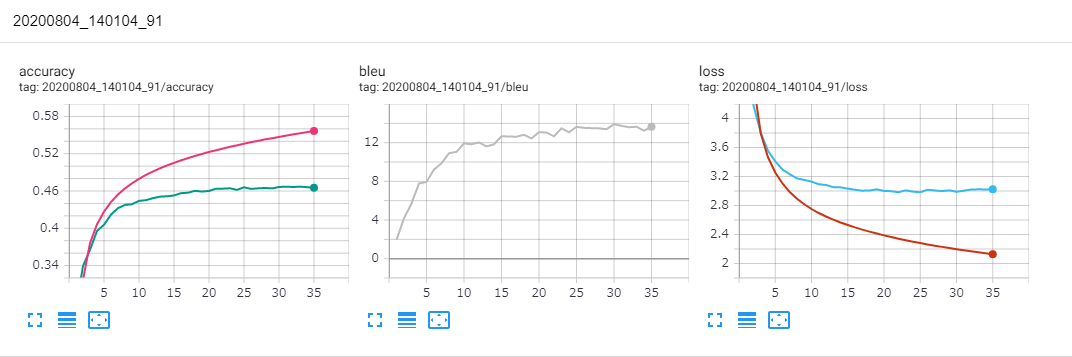

In [1]:
from IPython.display import Image
Image("imgs/20200804_140104_91.png")

In [6]:
if __name__ == '__main__':
    !jupyter nbconvert --to python Chapter10_91.ipynb

[NbConvertApp] Converting notebook Chapter10_91.ipynb to python
[NbConvertApp] Writing 26675 bytes to Chapter10_91.py
